In [4]:
# Wstępne spreparowanie embeddingów dla CCI, żeby zaoszczędzić na złożoności czasowej i obliczeniowej
import pandas as pd
import json
import numpy as np
import os
from sentence_transformers import SentenceTransformer

# Wczytujemy klasy CCI
with open("../data/cci_sample.json", "r", encoding="utf-8") as f:
    cci_data = json.load(f)

cci_df = pd.DataFrame(cci_data)

# Model embeddingowy
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Ścieżka do pliku z embeddingami
cci_emb_path = "../data/cci_embeddings.npy"

# Sprawdzamy czy embeddingi już są
if os.path.exists(cci_emb_path):
    print("Wczytywanie zapisanych embeddingów CCI...")
    cci_embeddings = np.load(cci_emb_path)
else:
    print("Generowanie embeddingów CCI i zapis do pliku...")
    cci_embeddings = model.encode(cci_df["full_text"].tolist(), convert_to_tensor=False)
    np.save(cci_emb_path, cci_embeddings)

# Sprawdzenie liczby embeddingów
print(f"Liczba embeddingów CCI: {len(cci_embeddings)}")

Generowanie embeddingów CCI i zapis do pliku...
Liczba embeddingów CCI: 11


In [10]:
from sentence_transformers import util

# Wczytujemy dane IFC
ifc_df = pd.read_csv("../data/ifc_sample.csv")

# Generujemy embeddingi IFC
ifc_embeddings = model.encode(ifc_df["Text"].tolist(), convert_to_tensor=False)

# Klasyfikujemy IFC względem CCI
results = []
threshold = 0.065 # można zmieniać wg uznania

for i, ifc_emb in enumerate(ifc_embeddings):
    similarities = util.cos_sim(ifc_emb, cci_embeddings)[0]
    best_idx = similarities.argmax().item()
    best_score = similarities[best_idx].item()

    if best_score < threshold:
        predicted_code = "N/A"
        predicted_name = "Brak jednoznacznej klasyfikacji"
    else:
        predicted_code = cci_df.loc[best_idx, "code"]
        predicted_name = cci_df.loc[best_idx, "name"]

    true_code = ifc_df.loc[i, "Prawdziwy_Kod_CCI"] if "Prawdziwy_Kod_CCI" in ifc_df.columns else None

    results.append({
        "GlobalId": ifc_df.loc[i, "GlobalId"],
        "Opis_IFC": ifc_df.loc[i, "Text"],
        "Przewidywany_Kod_CCI": predicted_code,
        "Przewidywana_Klasa_CCI": predicted_name,
        "Podobieństwo": round(best_score, 4),
        "Prawdziwy_Kod_CCI": true_code
    })

# Tworzymy DataFrame z wynikami
results_df = pd.DataFrame(results)

# Ewaluacja
if results_df["Prawdziwy_Kod_CCI"].notnull().all():
    results_df["Poprawność"] = results_df["Przewidywany_Kod_CCI"] == results_df["Prawdziwy_Kod_CCI"]
    accuracy = results_df["Poprawność"].mean()
    print(f"Top-1 Accuracy: {accuracy:.2%}")
else:
    print("Brak kolumny Prawdziwy_Kod_CCI lub zawiera puste wartości.")

# Sortowanie
results_df.sort_values("Podobieństwo", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Podgląd
results_df.head(10)

Top-1 Accuracy: 40.00%


,GlobalId,Opis_IFC,Przewidywany_Kod_CCI,Przewidywana_Klasa_CCI,Podobieństwo,Prawdziwy_Kod_CCI,Poprawność
0,2N3O4P,"Balustrada stalowa, IfcRailing, Balustrada z w...",24.61.10,Balustrady,0.7652,24.61.10,True
1,9K0L1M,"Dach dwuspadowy, IfcRoof, Konstrukcja drewnian...",22.11.10,Dachy,0.7450,22.11.10,True
2,1X2Y3Z,"Ściana zewnętrzna, IfcWall, Ściana zewnętrzna,...",21.12.10,Ściany wewnętrzne,0.7170,21.11.10,False
3,4A5B6C,"Drzwi jednoskrzydłowe, IfcDoor, Drzwi z drewna...",23.32.10,Drzwi wewnętrzne,0.6835,23.32.10,True
4,8T9U0V,"Drzwi przeciwpożarowe, IfcDoor, Drzwi EI60 sta...",23.32.10,Drzwi wewnętrzne,0.5878,23.31.10,False
5,0A1B2C,"Strop żelbetowy, IfcSlab, Strop monolityczny z...",21.51.10,Fundamenty,0.5714,22.31.10,False
6,3E4F5G,"Słup stalowy, IfcColumn, Słup stalowy HEA, wys...",22.31.10,Stropy,0.5318,21.41.10,False
7,5Q6R7S,"Schody prefabrykowane, IfcStair, Schody żelbet...",22.31.10,Stropy,0.5304,23.41.10,False
8,7D8E9F,"Okno PCV, IfcWindow, Okno dwuszybowe PCV, rozw...",23.21.10,Okna,0.5208,23.21.10,True
9,6H7I8J,"Płyta fundamentowa, IfcSlab, Płyta żelbetowa, ...",22.31.10,Stropy,0.4735,21.51.10,False


In [11]:
# Błędne klasyfikacje do analizy
results_df[results_df["Poprawność"] == False].head()

,GlobalId,Opis_IFC,Przewidywany_Kod_CCI,Przewidywana_Klasa_CCI,Podobieństwo,Prawdziwy_Kod_CCI,Poprawność
2,1X2Y3Z,"Ściana zewnętrzna, IfcWall, Ściana zewnętrzna,...",21.12.10,Ściany wewnętrzne,0.7170,21.11.10,False
4,8T9U0V,"Drzwi przeciwpożarowe, IfcDoor, Drzwi EI60 sta...",23.32.10,Drzwi wewnętrzne,0.5878,23.31.10,False
5,0A1B2C,"Strop żelbetowy, IfcSlab, Strop monolityczny z...",21.51.10,Fundamenty,0.5714,22.31.10,False
6,3E4F5G,"Słup stalowy, IfcColumn, Słup stalowy HEA, wys...",22.31.10,Stropy,0.5318,21.41.10,False
7,5Q6R7S,"Schody prefabrykowane, IfcStair, Schody żelbet...",22.31.10,Stropy,0.5304,23.41.10,False


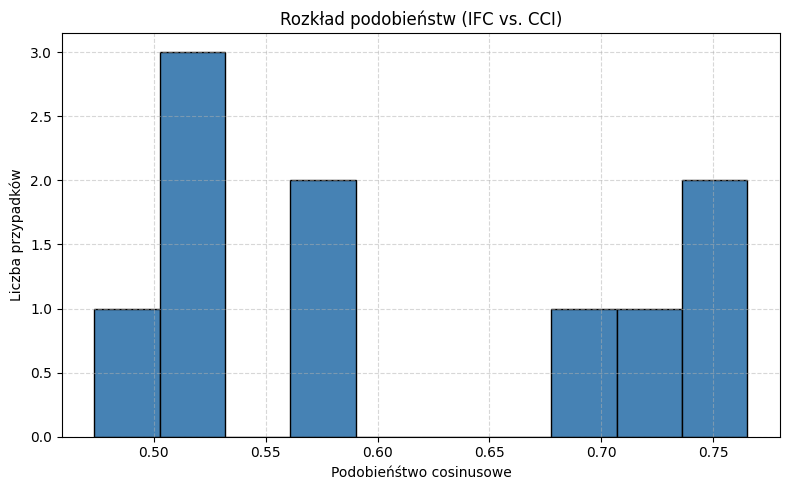

In [12]:
# Histogram rozkładu podobieństw
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(results_df["Podobieństwo"], bins=10, color="steelblue", edgecolor="black")
plt.title("Rozkład podobieństw (IFC vs. CCI)")
plt.xlabel("Podobieńśtwo cosinusowe")
plt.ylabel("Liczba przypadków")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# Eksport wyników do JSON (just for now)(subject to change)
baseline_output = []

for _, row in results_df.iterrows():
    baseline_output.append({
        "GlobalId": row["GlobalId"],
        "Opis": row["Opis_IFC"],
        "Predykcja": {
            "Kod_CCI": row["Przewidywany_Kod_CCI"],
            "Nazwa": row["Przewidywana_Klasa_CCI"],
            "Podobieństwo": row["Podobieństwo"]
        }
    })

# Zapisz do pliku
import json
with open("../results/baseline_predictions.json", "w", encoding="utf-8") as f:
    json.dump(baseline_output, f, ensure_ascii=False, indent=2)